## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## And so on and so forth...

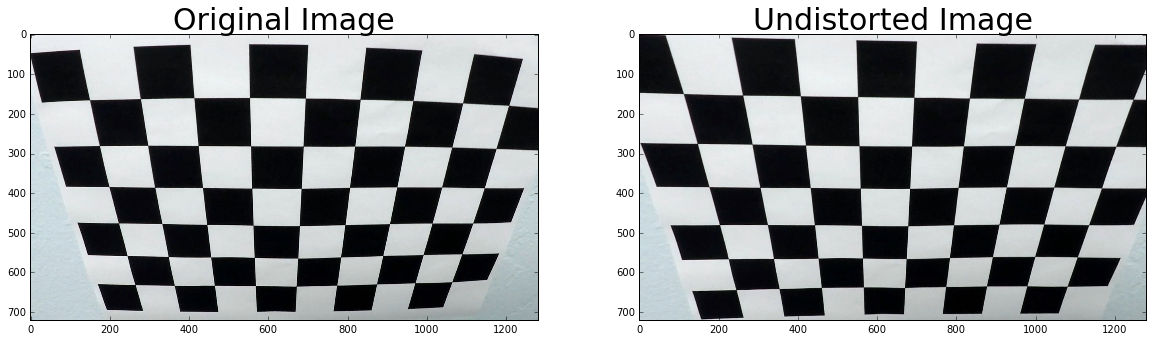

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('saurabh_test_undist.jpg', dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

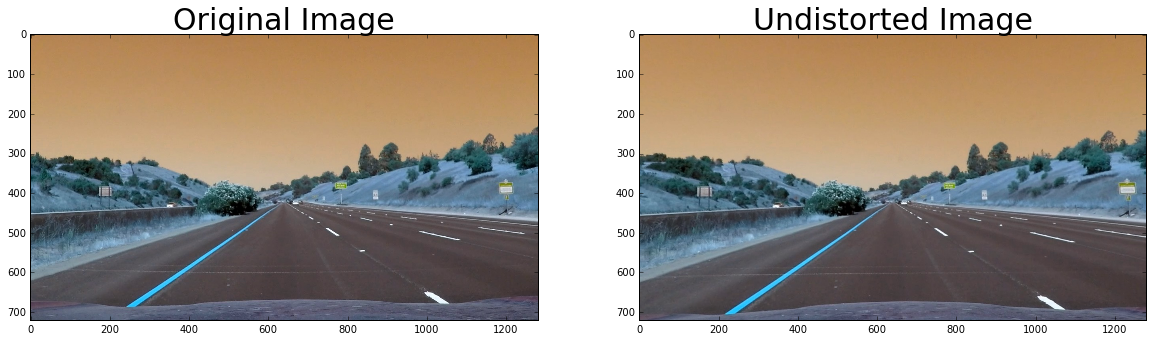

In [3]:
img = cv2.imread('../test_images/straight_lines1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=30)

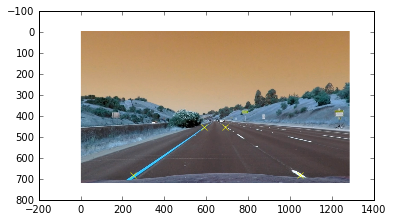

In [4]:
# Find corners on src to pinch from
undist = cv2.undistort(img, mtx, dist, None, mtx)

src = np.float32([[520, 500], [765, 500], \
                              [1050, 680], \
                  [250, 680]])

src = np.float32([[590, 450], [690, 450], \
                              [1050, 680], \
                  [250, 680]])
                              
# plt.rcParams["figure.figsize"] = [12, 9]        
# gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
plt.imshow(undist)
for x in range(len(src)):
    plt.plot(src[x][0], src[x][1], "x", color = 'yellow', linewidth=5)

In [5]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])

#     src = np.float32([[520, 500], [765, 500], \
#                                   [1050, 680], \
#                       [250, 680]])

    src = np.float32([[590, 450], [690, 450], \
                                  [1050, 680], \
                      [250, 680]])

    dst = np.float32([[240, 250], [1075, 250], 
                                 [1075, 680], \
                      [240, 680]])
# 
#     dst = np.float32([[200, 250], [1100, 250], 
#                                   [1050, 680], \
#                       [250, 680]])

#     dst = np.float32([[320, 1], [920, 1] ,\
#                                 [920, 720], \
#                       [320,720]]) 

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    return warped, M, Minv

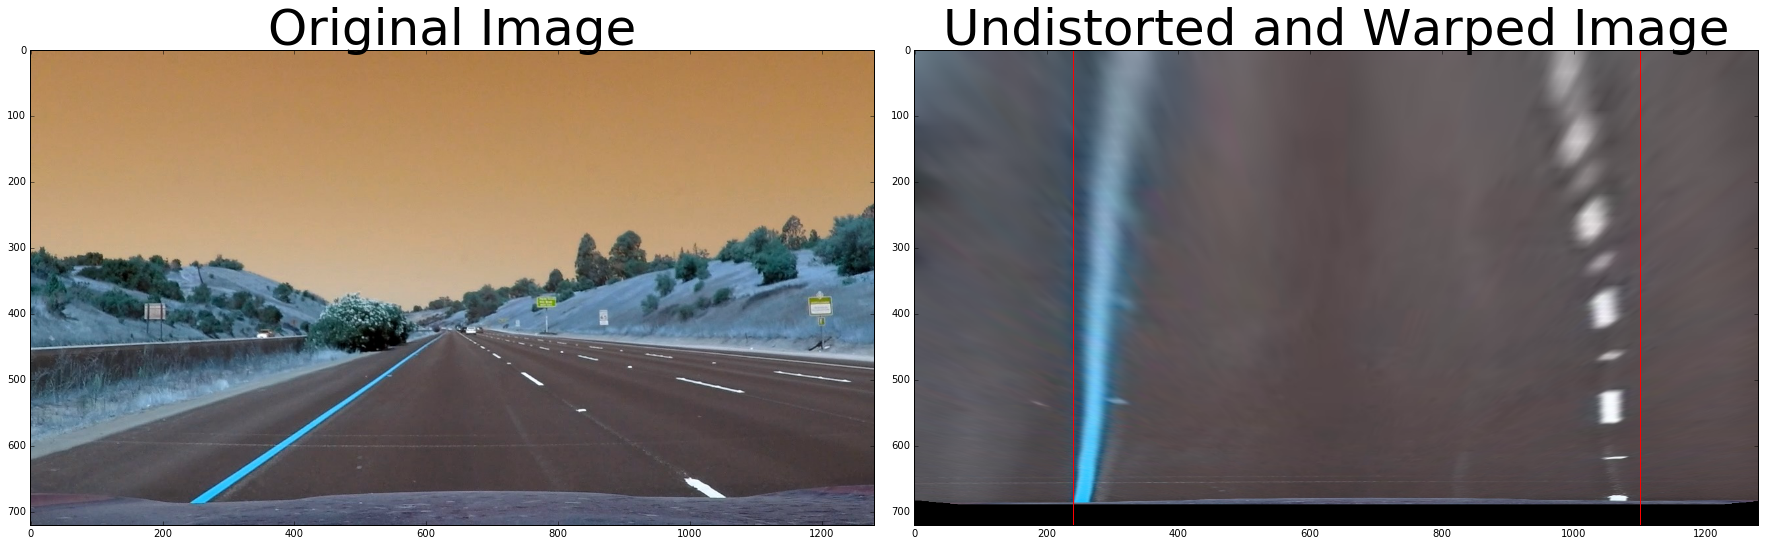

In [6]:
nx, ny = 9, 6
top_down, perspective_M, Minv = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.axvline(x=240, color='red')
ax2.axvline(x=1100, color='red')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

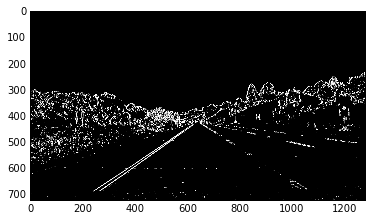

In [7]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    sxbinary = np.zeros_like(scaled_sobel)
            # is > thresh_min and < thresh_max
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary
    
# Run the function
grad_binary = abs_sobel_thresh(img, orient='x', thresh=(20, 100))
plt.imshow(grad_binary, cmap='gray')

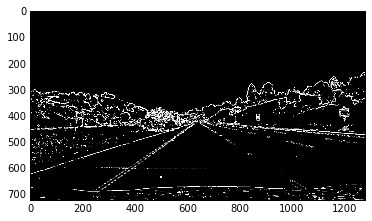

In [8]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
plt.imshow(mag_binary, cmap='gray')

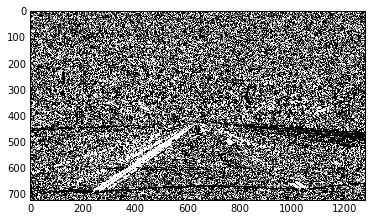

In [9]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_binary, cmap='gray')

In [10]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', thresh=(30, 100))
grady = abs_sobel_thresh(img, orient='y', thresh=(30, 100))
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))

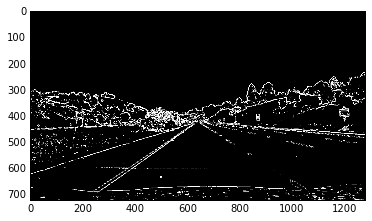

In [11]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray')

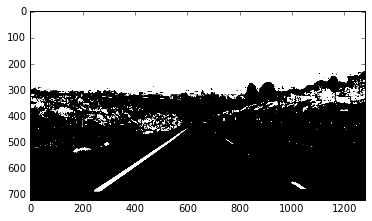

In [12]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(img, thresh=(90, 255))
plt.imshow(hls_binary, cmap='gray')

In [13]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
#     return color_binary
#     combined_binary = np.zeros_like(sxbinary)
#     combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
#     return combined_binary
    return s_binary
    

(720, 1280)


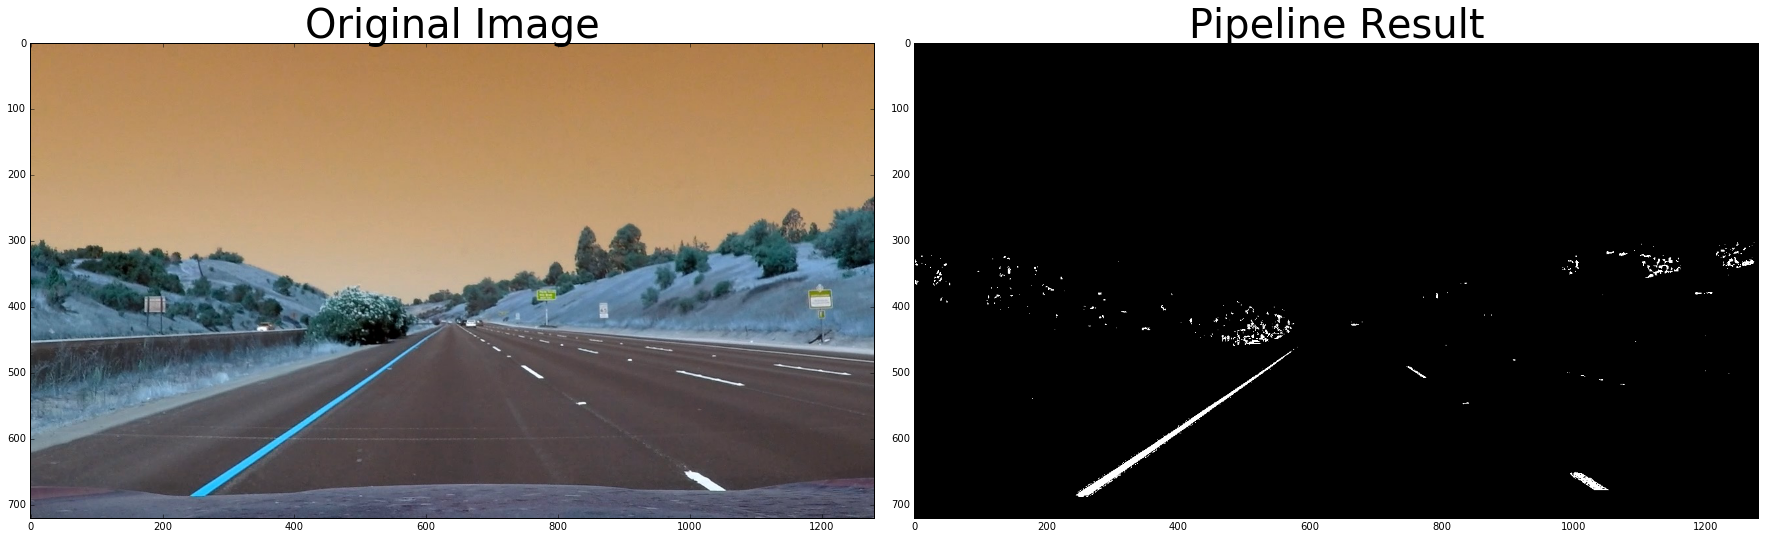

In [14]:
result = pipeline(img)
print(result.shape)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result,cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

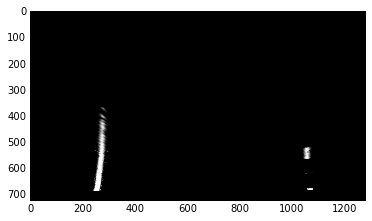

In [15]:
thresholded = pipeline(img)
warped, perspective_M, Minv = corners_unwarp(thresholded, nx, ny, mtx, dist)
plt.imshow(warped, cmap='gray')

In [16]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 10 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window_y = []
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    window_y.append(int(warped.shape[1]/2))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        window_y.append(int(warped.shape[0]-(level+1)*window_height))

    return window_centroids, window_y

In [17]:
print(warped.shape)
window_centroids, window_y = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

(720, 1280)


[(262.0, 1056.0), (265.0, 1054.0), (273.0, 1052.0), (275.0, 1042.0), (275.0, 1032.0), (265.0, 1022.0), (255.0, 1012.0), (245.0, 1002.0), (235.0, 992.0)]
[640, 560, 480, 400, 320, 240, 160, 80, 0]


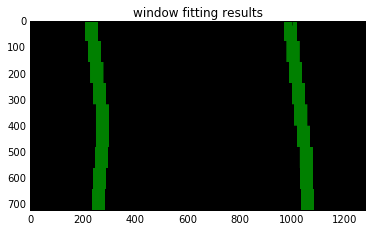

In [18]:
print(window_centroids)
print(window_y)
# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [19]:
for level in range(1,(int)(warped.shape[0]/window_height)):
    print(window_y[level], window_centroids[level])

560 (265.0, 1054.0)
480 (273.0, 1052.0)
400 (275.0, 1042.0)
320 (275.0, 1032.0)
240 (265.0, 1022.0)
160 (255.0, 1012.0)
80 (245.0, 1002.0)
0 (235.0, 992.0)


In [20]:
#left_fit = np.polyfit(y, x, 2)
window_centroids_x = np.array(window_centroids)
left_fit = np.polyfit(window_y, window_centroids_x[:,0], 2)
right_fit = np.polyfit(window_y, window_centroids_x[:,1], 2)

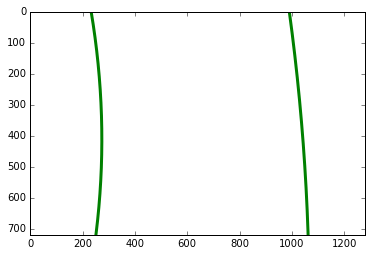

In [21]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

# Fit a second order polynomial to pixel positions in each fake lane line
#left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
# plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
# plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [22]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

2152.92532941 5879.82082303


In [23]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

NameError: name 'leftx' is not defined

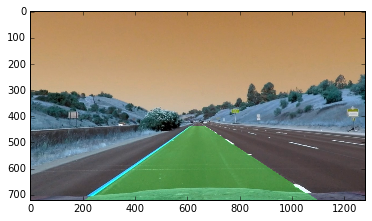

In [24]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [25]:
#WIP
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [30]:
def full_pipeline(image):
    thresholded = pipeline(image)
    nx, ny = 9, 6
    warped, perspective_M, Minv = corners_unwarp(thresholded, nx, ny, mtx, dist)
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 10 # How much to slide left and right for searching
    window_centroids, window_y = find_window_centroids(warped, window_width, window_height, margin)

    window_centroids_x = np.array(window_centroids)
    left_fit = np.polyfit(window_y, window_centroids_x[:,0], 2)
    right_fit = np.polyfit(window_y, window_centroids_x[:,1], 2)
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

#     # Fit new polynomials to x,y in world space
#     left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
#     right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
#     # Calculate the new radii of curvature
#     left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
#     right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
#     # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
#     # Example values: 632.1 m    626.2 m
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result#, left_fit, right_fit

1818.56836102 2268.06978882


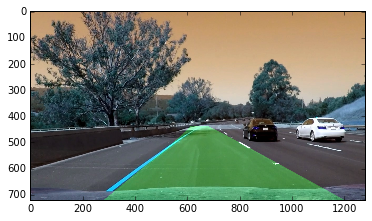

In [29]:
i = cv2.imread('../test_images/test6.jpg')
rslts, left_fit, right_fit = full_pipeline(i)
plt.imshow(rslts)

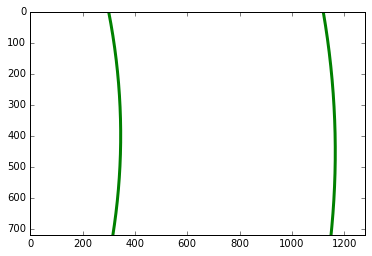

In [31]:
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
# plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
# plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [32]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'test.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(full_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


9679.5420965 10658.7169471
[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

9679.5420965 10658.7169471
8174.68644636 11856.2418219


  0%|          | 2/1261 [00:00<01:46, 11.86it/s]

10658.7169471 17850.6796093


  0%|          | 4/1261 [00:00<01:44, 12.00it/s]

9679.5420965 26850.8742471
10658.7169471 8.98262804586e+16


  0%|          | 6/1261 [00:00<01:43, 12.10it/s]

8174.68644636 8.98262804586e+16


  1%|          | 8/1261 [00:00<01:42, 12.18it/s]

9679.5420965 7.33387456297e+16
10658.7169471 6232.0098456
11856.2418219 5569.54564052


  1%|          | 10/1261 [00:00<01:42, 12.22it/s]

9679.5420965 10394.9480089
9679.5420965 15280.6603327


  1%|          | 12/1261 [00:00<01:40, 12.40it/s]

11856.2418219 26850.8742471


  1%|          | 14/1261 [00:01<01:39, 12.55it/s]

11856.2418219 10658.7169471
10658.7169471 10658.7169471
13353.9989208 21450.0732277


  1%|▏         | 16/1261 [00:01<01:38, 12.63it/s]

11856.2418219 7.27841759389e+16
11856.2418219 2.1740778249e+17


  1%|▏         | 18/1261 [00:01<01:38, 12.65it/s]

10658.7169471 7.27841759389e+16


  2%|▏         | 20/1261 [00:01<01:37, 12.67it/s]

10658.7169471 2.00540141404e+17
11856.2418219 5569.54564052
15280.6603327 5569.54564052


  2%|▏         | 22/1261 [00:01<01:37, 12.65it/s]

15280.6603327 6731.05585124
15280.6603327 13353.9989208


  2%|▏         | 24/1261 [00:01<01:37, 12.66it/s]

13353.9989208 17850.6796093


  2%|▏         | 26/1261 [00:02<01:38, 12.55it/s]

13353.9989208 26850.8742471
13353.9989208 10658.7169471
15280.6603327 10658.7169471


  2%|▏         | 28/1261 [00:02<01:41, 12.20it/s]

13353.9989208 11856.2418219
15280.6603327 26850.8742471


  2%|▏         | 30/1261 [00:02<01:41, 12.15it/s]

13353.9989208 5.66958788414e+16


  3%|▎         | 32/1261 [00:02<01:39, 12.29it/s]

9679.5420965 1.35471968692e+17
8864.12917211 6.96306164372e+16
8174.68644636 5569.54564052


  3%|▎         | 34/1261 [00:02<01:39, 12.36it/s]

9679.5420965 5569.54564052
9679.54209649 7449.07817003


  3%|▎         | 36/1261 [00:02<01:39, 12.33it/s]

8174.68644636 10658.7169471


  3%|▎         | 38/1261 [00:03<01:39, 12.33it/s]

9679.5420965 11856.2418219
10658.7169471 10658.7169471
9679.5420965 10658.7169471


  3%|▎         | 40/1261 [00:03<01:40, 12.11it/s]

8864.12917211 15280.6603327
8864.12917211 3.0325400409e+17


  3%|▎         | 42/1261 [00:03<01:41, 12.00it/s]

8864.12917211 1.32045570121e+17


  3%|▎         | 44/1261 [00:03<01:42, 11.88it/s]

8864.12917211 7.27841759389e+16
9679.5420965 7.27841759389e+16
9679.5420965 7717.46571626


  4%|▎         | 46/1261 [00:03<01:41, 11.96it/s]

9679.5420965 5569.54564052
10658.7169471 5569.54564052


  4%|▍         | 48/1261 [00:03<01:41, 11.95it/s]

10658.7169471 8864.12917211


  4%|▍         | 50/1261 [00:04<01:40, 12.05it/s]

10658.7169471 10658.7169471
10658.7169471 17850.6796093
13353.9989208 10658.7169471


  4%|▍         | 52/1261 [00:04<01:39, 12.21it/s]

11856.2418219 11856.2418219
11856.2418219 107904.042138


  4%|▍         | 54/1261 [00:04<01:38, 12.28it/s]

11856.2418219 8.20224954712e+16


  4%|▍         | 56/1261 [00:04<01:39, 12.15it/s]

11856.2418219 8.20224954712e+16
13353.9989208 1.32045570121e+17
13353.9989208 8.20224954712e+16


  5%|▍         | 58/1261 [00:04<01:39, 12.10it/s]

13353.9989208 5569.54564052
13353.9989208 5569.54564052


  5%|▍         | 60/1261 [00:04<01:39, 12.09it/s]

13353.9989208 8864.12917211


  5%|▍         | 62/1261 [00:05<01:39, 12.07it/s]

13353.9989208 10658.7169471
13353.9989208 10658.7169471
13353.9989208 10658.7169471


  5%|▌         | 64/1261 [00:05<01:39, 12.07it/s]

15280.6603327 10658.7169471
21450.0732277 21450.0732277


  5%|▌         | 66/1261 [00:05<01:37, 12.23it/s]

15280.6603327 1.12514689717e+17


  5%|▌         | 68/1261 [00:05<01:37, 12.23it/s]

15280.6603327 8.30804990191e+16
15280.6603327 8.66469971977e+17
10658.7169471 1.25905519345e+17


  6%|▌         | 70/1261 [00:05<01:37, 12.17it/s]

9679.5420965 5962.56826884
10658.7169471 6955.18670689


  6%|▌         | 72/1261 [00:05<01:37, 12.17it/s]

8864.12917211 7072.93379228


  6%|▌         | 74/1261 [00:06<01:36, 12.33it/s]

8864.1291721 9679.5420965
8864.12917211 10658.7169471
8864.12917211 15280.6603327


  6%|▌         | 76/1261 [00:06<01:35, 12.36it/s]

8864.12917211 10658.7169471
10658.7169471 17850.6796093
13353.9989208 53865.1623656


  6%|▌         | 78/1261 [00:06<01:42, 11.58it/s]

15280.6603327 1.46505186354e+17
13353.9989208 1.15492316586e+17


  6%|▋         | 80/1261 [00:06<01:43, 11.44it/s]

13353.9989208 1.15492316586e+17


  7%|▋         | 82/1261 [00:06<01:41, 11.59it/s]

13353.9989208 8.32018888762e+16
15280.6603327 9679.5420965


  7%|▋         | 84/1261 [00:06<01:41, 11.62it/s]

13353.9989208 6625.9815622


  7%|▋         | 86/1261 [00:07<01:39, 11.86it/s]

13353.9989208 9252.38876321
15280.6603327 11856.2418219
15280.6603327 17850.6796093


  7%|▋         | 88/1261 [00:07<01:37, 12.09it/s]

9679.5420965 10658.7169471
8174.68644636 10658.7169471


  7%|▋         | 90/1261 [00:07<01:37, 11.95it/s]

9461.18431906 26850.8742471


  7%|▋         | 92/1261 [00:07<01:38, 11.86it/s]

9461.18431906 53865.1623656
10658.7169471 53865.1623656
10658.7169471 8.73320162032e+16


  7%|▋         | 94/1261 [00:07<01:37, 11.94it/s]

10658.7169471 1.15944984207e+17
11856.2418219 5569.54564052


  8%|▊         | 96/1261 [00:07<01:37, 11.98it/s]

10658.7169471 5569.54564052


  8%|▊         | 98/1261 [00:08<01:36, 12.00it/s]

9679.5420965 5569.54564052
8174.68644636 11856.2418219
8864.12917211 15280.6603327


  8%|▊         | 100/1261 [00:08<01:37, 11.96it/s]

8864.12917211 15280.6603327
9679.54209649 10658.7169471


  8%|▊         | 102/1261 [00:08<01:38, 11.72it/s]

9679.5420965 21450.0732277


  8%|▊         | 104/1261 [00:08<01:37, 11.85it/s]

9679.5420965 21450.0732277
10658.7169471 1.15944984207e+17
8864.12917211 1.15492316586e+17


  8%|▊         | 106/1261 [00:08<01:40, 11.52it/s]

10658.7169471 1.15492316586e+17
9679.5420965 1.10552622107e+17


  9%|▊         | 108/1261 [00:08<01:39, 11.59it/s]

10658.7169471 5569.54564052


  9%|▊         | 110/1261 [00:09<01:37, 11.83it/s]

9679.5420965 5569.54564052
9679.5420965 10394.9480089
9679.5420965 13353.9989208


  9%|▉         | 112/1261 [00:09<01:36, 11.86it/s]

8174.68644636 21450.0732277
9679.54209649 13353.9989208


  9%|▉         | 114/1261 [00:09<01:36, 11.86it/s]

8864.12917211 10658.7169471


  9%|▉         | 116/1261 [00:09<01:36, 11.91it/s]

8864.12917211 13353.9989208
9679.5420965 21450.0732277
8864.12917211 8.30804990191e+16


  9%|▉         | 118/1261 [00:09<01:36, 11.80it/s]

9679.5420965 7.67718455532e+16
10658.7169471 7.67718455532e+16


 10%|▉         | 120/1261 [00:09<01:36, 11.87it/s]

8864.12917211 1.12514689717e+17


 10%|▉         | 122/1261 [00:10<01:35, 11.98it/s]

8864.12917211 6232.0098456
8174.68644636 5569.54564052
8864.1291721 9679.5420965


 10%|▉         | 124/1261 [00:10<01:33, 12.13it/s]

8864.1291721 13353.9989208
9679.5420965 13353.9989208


 10%|▉         | 126/1261 [00:10<01:34, 11.98it/s]

9679.54209649 10658.7169471


 10%|█         | 128/1261 [00:10<01:34, 12.00it/s]

9679.54209649 10658.7169471
8864.1291721 21450.0732277
9679.54209649 53865.1623656


 10%|█         | 130/1261 [00:10<01:33, 12.09it/s]

8864.12917211 1.24009205885e+17
8174.68644636 1.68406278729e+17


 10%|█         | 132/1261 [00:10<01:32, 12.18it/s]

9679.5420965 1.24009205885e+17
8174.68644636 5798.24275085
9679.5420965 5569.54564052


 11%|█         | 134/1261 [00:11<01:37, 11.61it/s]

10658.7169471 7584.21985848


 11%|█         | 136/1261 [00:11<01:34, 11.90it/s]

9679.5420965 10658.7169471
10658.7169471 15280.6603327


 11%|█         | 138/1261 [00:11<01:34, 11.92it/s]

10658.7169471 17850.6796093
11856.2418219 10658.7169471


 11%|█         | 140/1261 [00:11<01:41, 10.99it/s]

17850.6796093 13353.9989208


 11%|█▏        | 142/1261 [00:11<01:41, 11.05it/s]

13353.9989208 26850.8742471
13353.9989208 2.1740778249e+17
11856.2418219 1.35471968692e+17


 11%|█▏        | 144/1261 [00:11<01:38, 11.39it/s]

13353.9989208 1.32045570121e+17
10658.7169471 7.27841759389e+16


 12%|█▏        | 146/1261 [00:12<01:36, 11.50it/s]

8864.12917211 5569.54564052
8864.12917211 5569.54564052


 12%|█▏        | 148/1261 [00:12<01:44, 10.70it/s]

7072.93379227 8174.68644636
7072.93379227 10658.7169471
8864.1291721 11856.2418219


 12%|█▏        | 150/1261 [00:12<01:44, 10.66it/s]

7584.21985848 10658.7169471


 12%|█▏        | 152/1261 [00:12<01:39, 11.14it/s]

10658.7169471 10658.7169471
9679.5420965 17850.6796093


 12%|█▏        | 154/1261 [00:12<01:36, 11.45it/s]

10658.7169471 107904.042138


 12%|█▏        | 156/1261 [00:13<01:34, 11.64it/s]

11856.2418219 7.27841759389e+16
11856.2418219 7.27841759389e+16
11856.2418219 1.32045570121e+17


 13%|█▎        | 158/1261 [00:13<01:34, 11.66it/s]

10658.7169471 4694.6616474
13353.9989208 6731.05585124


 13%|█▎        | 160/1261 [00:13<01:32, 11.86it/s]

11856.2418219 9679.5420965


 13%|█▎        | 162/1261 [00:13<01:31, 12.00it/s]

13353.9989208 10658.7169471
11856.2418219 17850.6796093
9679.5420965 10658.7169471


 13%|█▎        | 164/1261 [00:13<01:32, 11.87it/s]

9679.54209649 10658.7169471
10658.7169471 13353.9989208


 13%|█▎        | 166/1261 [00:13<01:31, 12.02it/s]

10658.7169471 35854.4932788


 13%|█▎        | 168/1261 [00:14<01:31, 12.00it/s]

9679.5420965 6.07770072598e+16
11856.2418219 6.42997889865e+16
11856.2418219 1.68406278729e+17


 13%|█▎        | 170/1261 [00:14<01:31, 11.95it/s]

10658.7169471 6.42997889865e+16
11856.2418219 7072.93379228


 14%|█▎        | 172/1261 [00:14<01:29, 12.11it/s]

11856.2418219 5569.54564052
11856.2418219 11856.2418219
11856.2418219 17850.6796093


 14%|█▍        | 176/1261 [00:14<01:39, 10.95it/s]

13353.9989208 15280.6603327
10658.7169471 10658.7169471
10658.7169471 21450.0732277


 14%|█▍        | 180/1261 [00:15<01:38, 11.03it/s]

11856.2418219 21450.0732277
13353.9989208 53865.1623656
15280.6603327 107904.042138


 14%|█▍        | 182/1261 [00:15<01:41, 10.66it/s]

13353.9989208 1.15843699673e+17
15280.6603327 7.67718455532e+16
21450.0732277 6232.0098456


 15%|█▍        | 184/1261 [00:15<01:39, 10.82it/s]

17850.6796093 5569.54564052
11856.2418219 7584.21985848
10658.7169471 10658.7169471


 15%|█▍        | 188/1261 [00:15<01:42, 10.44it/s]

10658.7169471 10658.7169471
9679.5420965 10658.7169471
9679.54209649 10658.7169471


 15%|█▌        | 192/1261 [00:16<01:34, 11.30it/s]

8864.12917211 13353.9989208
10658.7169471 1.20347013969e+17
9679.54209649 1.68406278729e+17


 15%|█▌        | 194/1261 [00:16<01:41, 10.51it/s]

10658.7169471 1.68406278729e+17
9679.5420965 6.42997889865e+16


 16%|█▌        | 196/1261 [00:16<01:40, 10.60it/s]

9679.5420965 8174.68644636
10658.7169471 5569.54564052
10658.7169471 7584.21985848


 16%|█▌        | 200/1261 [00:16<01:34, 11.21it/s]

11856.2418219 11856.2418219
13353.9989208 13353.9989208
13353.9989208 11856.2418219


 16%|█▌        | 202/1261 [00:17<01:38, 10.76it/s]

13353.9989208 10658.7169471
13353.9989208 15280.6603327
11856.2418219 107904.042138


 16%|█▋        | 206/1261 [00:17<01:33, 11.28it/s]

11856.2418219 1.53931308567e+17
10658.7169471 1.34378457125e+17
10658.7169471 6.42997889865e+16


 16%|█▋        | 208/1261 [00:17<01:38, 10.73it/s]

9679.5420965 5640.8050022
9679.5420965 7072.93379228


 17%|█▋        | 210/1261 [00:17<01:40, 10.51it/s]

10658.7169471 6232.0098456
11856.2418219 8864.12917211
13353.9989208 11856.2418219


 17%|█▋        | 214/1261 [00:18<01:36, 10.90it/s]

13353.9989208 10658.7169471
15280.6603327 10658.7169471
13353.9989208 10658.7169471


 17%|█▋        | 216/1261 [00:18<01:39, 10.51it/s]

11856.2418219 35854.4932788
9679.5420965 7.67718455532e+16


 17%|█▋        | 218/1261 [00:18<01:39, 10.47it/s]

8864.12917211 7.67718455532e+16
9679.5420965 8.30804990191e+16
8864.12917211 5.4335457552e+16


 17%|█▋        | 220/1261 [00:18<01:35, 10.94it/s]

10658.7169471 5569.54564052
10658.7169471 5569.54564052
13353.9989208 8174.68644636


 18%|█▊        | 224/1261 [00:19<01:41, 10.25it/s]

13353.9989208 10658.7169471
15280.6603327 10658.7169471
13353.9989208 10658.7169471


 18%|█▊        | 226/1261 [00:19<01:35, 10.78it/s]

13353.9989208 11856.2418219
10658.7169471 17850.6796093
11856.2418219 1.1522562514e+17


 18%|█▊        | 230/1261 [00:19<01:41, 10.14it/s]

11856.2418219 1.60779667356e+17
11856.2418219 1.15944984207e+17
13353.9989208 1.1522562514e+17


 19%|█▊        | 234/1261 [00:20<01:34, 10.87it/s]

15280.6603327 5569.54564052
17850.6796093 5569.54564052
17850.6796093 6625.9815622


 19%|█▊        | 236/1261 [00:20<01:37, 10.48it/s]

15280.6603327 10658.7169471
13353.9989208 10658.7169471
11856.2418219 10658.7169471


 19%|█▉        | 240/1261 [00:20<01:32, 10.99it/s]

13353.9989208 10658.7169471
13353.9989208 15280.6603327
11856.2418219 107904.042138


 19%|█▉        | 242/1261 [00:20<01:29, 11.38it/s]

15280.6603327 9.07761918165e+16
13353.9989208 8.43619920546e+16
11856.2418219 2.24058716405e+17


 19%|█▉        | 244/1261 [00:21<01:28, 11.44it/s]

13353.9989208 5569.54564052
13353.9989208 5569.54564052


 20%|█▉        | 246/1261 [00:21<01:34, 10.69it/s]

11856.2418219 7584.21985848
10658.7169471 9679.5420965


 20%|█▉        | 248/1261 [00:21<01:39, 10.16it/s]

3512.08259514 10658.7169471
9679.54209649 10658.7169471
13537.210706 10658.7169471


 20%|█▉        | 252/1261 [00:21<01:35, 10.51it/s]

9679.5420965 17850.6796093
9679.5420965 107904.042138
11856.2418219 8.60249419716e+16


 20%|██        | 254/1261 [00:22<01:37, 10.36it/s]

11856.2418219 9.07761918165e+16
11856.2418219 9.07761918165e+16


 20%|██        | 258/1261 [00:22<01:34, 10.63it/s]

10658.7169471 9.78611747124e+16
8174.68644636 5569.54564052
9679.5420965 5569.54564052


 21%|██        | 260/1261 [00:22<01:33, 10.75it/s]

8864.12917211 8174.68644636
9679.5420965 10658.7169471


 21%|██        | 262/1261 [00:22<01:38, 10.14it/s]

10658.7169471 10658.7169471
10658.7169471 10658.7169471


 21%|██        | 264/1261 [00:23<01:33, 10.70it/s]

10658.7169471 11856.2418219
10658.7169471 26850.8742471
10658.7169471 53865.1623656


 21%|██▏       | 268/1261 [00:23<01:28, 11.24it/s]

10658.7169471 107904.042138
9679.5420965 8.43619920546e+16
9679.5420965 9.07761918165e+16


 21%|██▏       | 270/1261 [00:23<01:32, 10.74it/s]

10658.7169471 47854.5636799
9679.5420965 7072.93379228
10658.7169471

 22%|██▏       | 274/1261 [00:23<01:27, 11.26it/s]

 10658.7169471
10658.7169471 13353.9989208
10658.7169471 10658.7169471
7318.65064575 10658.7169471


 22%|██▏       | 276/1261 [00:24<01:28, 11.09it/s]

7070.99520046 15280.6603327
7721.97947154 35854.4932788


 22%|██▏       | 278/1261 [00:24<01:32, 10.58it/s]

7721.97947154 107904.042138
7449.07817003 8.73320162032e+16
7721.97947154 1.6165829221e+17


 22%|██▏       | 282/1261 [00:24<01:28, 11.08it/s]

8504.13425583 2.24058716405e+17
9461.18431906 5569.54564052
8680.4262188 8174.68644636


 23%|██▎       | 284/1261 [00:24<01:31, 10.64it/s]

7721.97947154 15280.6603327
6624.31695323 26850.8742471


 23%|██▎       | 286/1261 [00:25<01:30, 10.76it/s]

6624.31695323 35854.4932788
5642.71797278 10658.7169471
6050.10347902 11856.2418219


 23%|██▎       | 288/1261 [00:25<01:30, 10.80it/s]

6520.91053554 21450.0732277
5719.94988474 21450.0732277
5642.71797278 9.20309702987e+16


 23%|██▎       | 292/1261 [00:25<01:34, 10.21it/s]

5286.86204231 1.46505186354e+17
4973.44188983 13353.9989208
5642.71797278 7072.93379228


 23%|██▎       | 296/1261 [00:25<01:30, 10.70it/s]

5642.71797278 7584.21985848
5642.71797278 19481.8263309
4973.44188983 26850.8742471


 24%|██▎       | 298/1261 [00:26<01:32, 10.45it/s]

5286.86204231 107904.042138
5220.88840834 10658.7169471
5286.86204231 13353.9989208


 24%|██▍       | 302/1261 [00:26<01:24, 11.34it/s]

6520.91053554 21450.0732277
5642.71797278 26850.8742471
5963.74093857 1.15843699673e+17


 24%|██▍       | 304/1261 [00:26<01:25, 11.16it/s]

6050.10347902 8.30804990191e+16
6420.68511095 5.4335457552e+16
6520.91053554 5882.18830412


 24%|██▍       | 308/1261 [00:27<01:25, 11.11it/s]

6520.91053554 6625.9815622
6871.03052994 9252.38876321
4672.37451091 17850.6796093


 25%|██▍       | 310/1261 [00:27<01:28, 10.79it/s]

4095.37400287 17850.6796093
3880.59962736 10658.7169471
3248.69988912 10658.7169471


 25%|██▍       | 314/1261 [00:27<01:23, 11.38it/s]

3077.82716998 26850.8742471
3144.54343911 8.66469971977e+17
2728.54241939 8.66469971977e+17


 25%|██▌       | 316/1261 [00:27<01:27, 10.76it/s]

2805.90077932 9.36278007666e+16
2822.00317627 8.49359996749e+16


 25%|██▌       | 318/1261 [00:27<01:30, 10.45it/s]

3174.91334627 7192.69756793
2389.48299683 6625.9815622
2675.17687061 86275.3163462


 25%|██▌       | 320/1261 [00:28<01:27, 10.74it/s]

2308.1326345 1.17965390397e+17
2258.15442261 11856.2418219
2444.02413128 10658.7169471


 26%|██▌       | 324/1261 [00:28<01:31, 10.28it/s]

2198.18035189 10658.7169471
2423.74108017 10658.7169471


 26%|██▌       | 326/1261 [00:28<01:33,  9.99it/s]

2302.5954592 10658.7169471
2234.14459415 86275.3163462
2161.41391532 12189.6982198


 26%|██▌       | 330/1261 [00:29<01:24, 10.98it/s]

2235.55078021 8498.64393858
2466.48833537 4643.43101364
2115.59940604 9679.5420965


 26%|██▋       | 332/1261 [00:29<01:22, 11.28it/s]

1997.78778594 11526.6974955
1949.37392476 8.66469971977e+17
1928.86212021 8.66469971977e+17


 26%|██▋       | 334/1261 [00:29<01:23, 11.06it/s]

1949.37392476 10658.7169471
1949.37392476 10658.7169471


 27%|██▋       | 336/1261 [00:29<01:27, 10.57it/s]

1988.45819628 11856.2418219
2111.2804419 17850.6796093
2102.29919031 6.07770072598e+16


 27%|██▋       | 340/1261 [00:30<01:23, 11.09it/s]

2029.46554958 28640.0542541
2077.75545271 28640.0542541
1990.14676664 8858.13201606


 27%|██▋       | 344/1261 [00:30<01:19, 11.53it/s]

2116.33469316 8864.12917211
1926.79777565 13784.422338
2079.06988196 107904.042138


 27%|██▋       | 346/1261 [00:30<01:17, 11.80it/s]

2241.51916073 53865.1623656
2307.00673768 10658.7169471
2156.08912423 10658.7169471


 28%|██▊       | 350/1261 [00:30<01:19, 11.46it/s]

2260.95424386 15355.2009762
2041.53309237 21450.0732277
2084.97667916 28640.0542541


 28%|██▊       | 352/1261 [00:31<01:17, 11.70it/s]

2250.07733685 12189.6982198
2199.39955077 7067.29477471
2283.61897101 4914.57936677


 28%|██▊       | 356/1261 [00:31<01:15, 12.05it/s]

2201.66756954 7192.69756793
2161.58145113 6622.70754661
2136.83700997 8858.13201606


 28%|██▊       | 358/1261 [00:31<01:18, 11.57it/s]

2360.94513911 53865.1623656
2234.01601457 10658.7169471
2512.59024884 10658.7169471


 29%|██▊       | 362/1261 [00:31<01:15, 11.84it/s]

2567.38865644 13353.9989208
2545.97124482 11945.7596462
2614.59850378 17120.880155


 29%|██▉       | 364/1261 [00:32<01:15, 11.85it/s]

2448.50891479 6517.89792161
2467.24272725 7717.46571626
2670.43986934 7318.65064575


 29%|██▉       | 366/1261 [00:32<01:15, 11.93it/s]

2631.88902604 9679.5420965
2695.29009585 11531.341475
2631.88902604 15280.6603327


 29%|██▉       | 370/1261 [00:32<01:17, 11.53it/s]

2474.35410443 17850.6796093
2348.49366164 10658.7169471
1928.24875709 10658.7169471


 30%|██▉       | 374/1261 [00:32<01:15, 11.73it/s]

1936.32670344 9768.96731395
2166.20778763 26850.8742471
1999.163301 28640.0542541


 30%|██▉       | 376/1261 [00:33<01:17, 11.46it/s]

1999.163301 28640.0542541
1940.32590297 14243.5410523
1912.58880266 4973.44188983


 30%|███       | 380/1261 [00:33<01:14, 11.82it/s]

1896.75450806 8174.68644636
1860.20300696 12938.5440586
2145.79935707 1.05486164752e+17


 30%|███       | 382/1261 [00:33<01:13, 11.93it/s]

2180.54074616 27323.5366458
2180.54074616 7657.53853467
2112.47704279 10658.7169471


 31%|███       | 386/1261 [00:33<01:15, 11.64it/s]

2021.98022025 10658.7169471
1835.45507498 21450.0732277
1914.90920609 26121.7297861


 31%|███       | 388/1261 [00:34<01:15, 11.51it/s]

1965.56243073 6168.44440543
2042.64733249 6047.68009833
2199.90593014 6010.74306778


 31%|███       | 392/1261 [00:34<01:12, 12.00it/s]

2304.34274964 5286.86204231
2263.99856761 6588.21997313
2515.1130891 7579.77934672


 31%|███       | 394/1261 [00:34<01:14, 11.67it/s]

2434.89277864 107904.042138
2440.72319045 8238.35468625
2492.7625773 13467.9628217


 32%|███▏      | 398/1261 [00:34<01:12, 11.92it/s]

2590.81856846 9738.9400605
2468.3902905 8964.33629631
2468.3902905 29142.6011697


 32%|███▏      | 400/1261 [00:35<01:11, 11.99it/s]

2579.97284006 7415.4978294
3079.45820648 6509.06412671
3035.18144827 5439.70476075


 32%|███▏      | 404/1261 [00:35<01:10, 12.17it/s]

3021.24136443 6262.73849607
3262.85217313 32728.6574469
3247.61939876 6215.94646588


 32%|███▏      | 406/1261 [00:35<01:11, 11.91it/s]

3008.15231316 22214.6812586
3375.72373825 9201.43591423
3110.60980632 6392.07581081


 33%|███▎      | 410/1261 [00:35<01:12, 11.74it/s]

3003.42792587 7133.17392938
3672.28283615 7062.94253211
3170.46237299 7385.74550764


 33%|███▎      | 412/1261 [00:36<01:11, 11.81it/s]

3588.39792439 6441.09648677
2903.80567476 6238.17207462
2974.81105041 4761.97374794


 33%|███▎      | 416/1261 [00:36<01:10, 11.91it/s]

2906.20467718 4695.38462304
2686.74808443 7946.19745371
2788.87833559 6302.84414879


 33%|███▎      | 418/1261 [00:36<01:10, 12.04it/s]

2367.80127578 35854.4932788
2855.51331093 8238.35468625
3073.06340469 8533.5680103


 33%|███▎      | 422/1261 [00:36<01:11, 11.71it/s]

2700.86763224 10829.6572181
2808.74881821 8303.27439651
2487.74279897 8.83464006095e+16


 34%|███▎      | 424/1261 [00:37<01:10, 11.89it/s]

2737.57085401 9454.49973073
2930.55778537 6739.48734395
2993.01932127 6041.61920396


 34%|███▍      | 428/1261 [00:37<01:08, 12.19it/s]

3376.31415534 6004.75446953
3547.88857862 6729.36808623
3115.65240371 7597.99781634


 34%|███▍      | 430/1261 [00:37<01:08, 12.18it/s]

3033.73536181 15661.555391
3073.47591317 6319.80681222
3396.16421976 5135.6307774


 34%|███▍      | 434/1261 [00:37<01:07, 12.31it/s]

3372.79373281 6646.71565797
3581.49375465 4361.09531512
3438.4273786 4793.17636203


 35%|███▍      | 436/1261 [00:38<01:07, 12.24it/s]

3238.08373912 6047.68009833
3129.60256136 7067.29477471
2373.41417528 4973.44188983


 35%|███▍      | 440/1261 [00:38<01:08, 11.91it/s]

2754.19403491 4480.30807645
2523.74647294 9900.82294697
2250.21878423 8.60249419716e+16


 35%|███▌      | 442/1261 [00:38<01:08, 12.04it/s]

2231.67420542 107904.042138
2018.0375035 8238.35468625
2387.9392709 5380.52930763


 35%|███▌      | 446/1261 [00:38<01:07, 12.13it/s]

3096.7465164 5399.49708888
2667.67078841 4793.80891394
2260.5179098 6517.89792161


 36%|███▌      | 448/1261 [00:39<01:06, 12.19it/s]

2216.36682394 9454.49973073
2228.02011921 6899.45739174
2290.96961154 7070.99520046


 36%|███▌      | 452/1261 [00:39<01:07, 11.95it/s]

2185.37321463 7070.99520046
1912.58880266 9049.449361
1953.65879052 37149.5312479


 36%|███▌      | 454/1261 [00:39<01:06, 12.09it/s]

1960.43451357 21749.1067757
2021.61921568 10658.7169471
1957.80586494 8238.35468625


 36%|███▋      | 458/1261 [00:39<01:07, 11.95it/s]

2021.61921568 8259.85399693
1860.20300696 8939.02574879
1835.45507498 10650.5386637


 36%|███▋      | 460/1261 [00:40<01:06, 12.05it/s]

1989.06975221 9157.23912277
1835.45507498 7717.46571626
1835.45507498 6520.91053554


 37%|███▋      | 464/1261 [00:40<01:05, 12.21it/s]

1788.62440692 6589.63481472
1930.02993879 5428.0558903
1835.45507498 9829.68917434


 37%|███▋      | 466/1261 [00:40<01:05, 12.14it/s]

1788.62440692 6006.7889995
1766.46011032 6710.62637311
1788.62440692 6319.80681222


 37%|███▋      | 470/1261 [00:40<01:04, 12.22it/s]

1788.62440692 6710.62637311
1811.60956858 6710.62637311
1963.39152783 6047.68009833


 37%|███▋      | 472/1261 [00:41<01:04, 12.20it/s]

1884.63876354 7067.29477471
1888.68062441 6517.89792161
1903.84479825 3776.58182004


 38%|███▊      | 476/1261 [00:41<01:07, 11.62it/s]

1873.40609744 3715.88537568
2024.3330654 2794.71089472
2252.25640988 4953.05998934


 38%|███▊      | 478/1261 [00:41<01:06, 11.74it/s]

2365.65714616 3732.39771429
2180.97385967 3732.39771429
2274.47530155 2779.18303226


 38%|███▊      | 482/1261 [00:41<01:05, 11.98it/s]

2686.75812796 2090.87005567
2396.17078501 2199.31905724
2424.21206744 2702.13167447


 38%|███▊      | 484/1261 [00:42<01:04, 11.97it/s]

2591.53533963 4480.56272816
2162.04279448 3105.70908859
2049.55100169 3474.5267751


 39%|███▊      | 488/1261 [00:42<01:03, 12.23it/s]

2011.56469496 2834.68916805
2010.4781609 3061.22354689
1900.79072347 3867.74265651


 39%|███▉      | 490/1261 [00:42<01:04, 12.04it/s]

1885.89826379 4153.36092355
1860.20300696 3732.39771429
1954.73616497 3891.57269732


 39%|███▉      | 494/1261 [00:42<01:04, 11.83it/s]

1874.36484759 3059.90547444
1985.38479486 4067.12919465
2120.20498891 4446.69641994


 39%|███▉      | 496/1261 [00:43<01:04, 11.90it/s]

2370.93312743 4446.69641994
1962.40637929 4446.69641994
2018.79894908 4137.38179954


 40%|███▉      | 500/1261 [00:43<01:03, 12.02it/s]

1941.68117864 4052.22075615
1961.58832663 4023.71047825
2230.02898306 3449.26556167


 40%|███▉      | 502/1261 [00:43<01:02, 12.05it/s]

2195.75418385 3732.39771429
2945.25320314 3732.39771429
2510.69072239 3867.74265651


 40%|████      | 506/1261 [00:43<01:02, 12.16it/s]

2323.57725547 2790.58097658
2212.29116676 3040.10076649
2199.57055946 2932.72677


 40%|████      | 508/1261 [00:44<01:02, 12.11it/s]

2390.43263732 3475.51110407
2412.7503258 3554.79543628
2686.41357308 4300.56502664


 41%|████      | 512/1261 [00:44<01:01, 12.25it/s]

2705.51505041 4382.10115104
2859.93441847 3682.08615076
2703.02781505 4116.81484275


 41%|████      | 514/1261 [00:44<01:01, 12.24it/s]

2551.50058913 5660.77759321
2724.89948365 4686.25398918
2588.77510006 4944.53889831


 41%|████      | 518/1261 [00:44<01:00, 12.21it/s]

2681.34425779 4558.74491791
3085.04477818 6134.45324804
4022.87026952 2925.92881598


 41%|████      | 520/1261 [00:45<01:00, 12.17it/s]

3315.39859307 18715.7150911
3194.73586169 10757.7813039
4182.23994534 8378.90316942


 42%|████▏     | 524/1261 [00:45<01:03, 11.70it/s]

3083.16070884 19104.3043575
3588.60007884 3976.6741042
2796.45531967 16576.8820658


 42%|████▏     | 526/1261 [00:45<01:02, 11.67it/s]

2831.75229416 6037.65567581
3200.77393275 5176.65397505
2528.23943403 10560.190279


 42%|████▏     | 530/1261 [00:45<01:02, 11.70it/s]

2678.30580893 4317.50191295
2745.92983885 4224.96325739
2315.26996256 9702.42336036


 42%|████▏     | 532/1261 [00:46<01:02, 11.75it/s]

2885.31148004 4587.84944062
2963.96979138 7791.83319465
2318.30166664 6428.02946933


 42%|████▏     | 534/1261 [00:46<01:03, 11.41it/s]

2055.52665905 9367.46892579
2428.52881356 8213.71791651
2185.37321463 5778.05885594


 43%|████▎     | 538/1261 [00:46<01:04, 11.23it/s]

2691.61104928 6504.53511611
2630.7469969 9447.54572325
2898.27529164 6029.16802576


 43%|████▎     | 542/1261 [00:47<01:01, 11.66it/s]

2758.82196747 7237.33628635
2642.31574321 6931.36107418
2694.57057609 6689.70035495


 43%|████▎     | 544/1261 [00:47<01:00, 11.78it/s]

2702.52046031 7906.172681
2744.57312545 28708.0320651
2667.58897801 11706.6539376


 43%|████▎     | 548/1261 [00:47<01:03, 11.29it/s]

2983.51615893 14494.8646808
3341.87120876 6409.09377503
3434.31447104 6876.58194416


 44%|████▎     | 550/1261 [00:47<01:01, 11.55it/s]

3415.0228226 10572.0247627
4732.31141312 10816.3111081
3609.76920657 12699.4267894


 44%|████▍     | 554/1261 [00:48<01:00, 11.74it/s]

3708.22964223 18272.2263483
2844.25723439 4684.9101725
3163.06060513 5865.37211679


 44%|████▍     | 556/1261 [00:48<01:00, 11.74it/s]

4152.8215574 10793.2931368
3235.48269325 4644.63733711
4695.38462304 47725.3176232


 44%|████▍     | 560/1261 [00:48<00:59, 11.85it/s]

4141.19172809 47725.3176232
4915.09145494 3732.39771429
13353.9989208 3379.50918321


 45%|████▍     | 562/1261 [00:48<00:58, 11.91it/s]

15280.6603327 8174.68644636
17850.6796093 1818.56836102
7318.65064575 1898.87017517


 45%|████▍     | 566/1261 [00:49<01:00, 11.53it/s]

4695.38462304 3475.51110407
5641.73798026 3104.57084175
3706.09967275 2751.15317377


 45%|████▌     | 568/1261 [00:49<00:59, 11.74it/s]

3673.85964858 3712.01210249
4061.53851617 4008.01167326
6050.10347902 3732.39771429


 45%|████▌     | 572/1261 [00:49<00:58, 11.85it/s]

5286.86204231 3732.39771429
4355.03136312 3150.90728383
4494.40189679 2419.00582147


 46%|████▌     | 574/1261 [00:49<00:58, 11.73it/s]

5286.86204231 2283.89373216
7070.99520046 2109.25143764
10658.7169471 3084.31491226


 46%|████▌     | 578/1261 [00:50<00:58, 11.70it/s]

10658.7169471 3820.44851749
17120.880155 4446.31983556
10140.0370327 6050.10347902


 46%|████▌     | 580/1261 [00:50<00:58, 11.55it/s]

10658.7169471 4973.44188983
5642.71797278 10658.7169471
10658.7169471 9709.13236598


 46%|████▋     | 584/1261 [00:50<00:57, 11.84it/s]

10658.7169471 7657.53853467
10658.7169471 9768.96731395
10658.7169471 13353.9989208


 46%|████▋     | 586/1261 [00:50<00:59, 11.43it/s]

10658.7169471 15280.6603327
10658.7169471 43046.4030005


 47%|████▋     | 588/1261 [00:51<01:02, 10.79it/s]

10658.7169471 21439.3417882
4.90752264817e+17 6519.37706461
7.46699074801e+17 9679.5420965


 47%|████▋     | 590/1261 [00:51<01:00, 11.01it/s]

6.68503926261e+17 14243.5410523
8504.13425583 5286.86204231


 47%|████▋     | 592/1261 [00:51<01:03, 10.53it/s]

8504.13425583 53865.1623656
10658.7169471 10658.7169471


 47%|████▋     | 594/1261 [00:51<01:04, 10.29it/s]

10658.7169471 10658.7169471
10658.7169471 3732.39771429


 47%|████▋     | 596/1261 [00:51<01:07,  9.92it/s]

10658.7169471 10658.7169471
10658.7169471 3437.29659497


 48%|████▊     | 599/1261 [00:52<01:07,  9.84it/s]

10658.7169471 8.49359996749e+16
13353.9989208 4446.69641994


 48%|████▊     | 601/1261 [00:52<01:08,  9.62it/s]

11856.2418219 4446.69641994
10658.7169471 3254.34267698


 48%|████▊     | 603/1261 [00:52<01:09,  9.52it/s]

10658.7169471 6520.91053554
11856.2418219 10658.7169471


 48%|████▊     | 605/1261 [00:52<01:09,  9.42it/s]

11856.2418219 4973.44188983
10658.7169471 10658.7169471


 48%|████▊     | 607/1261 [00:52<01:08,  9.58it/s]

10658.7169471 10658.7169471
10658.7169471 17850.6796093


 48%|████▊     | 609/1261 [00:53<01:08,  9.51it/s]

10658.7169471 10658.7169471
3135.87095277 10658.7169471


 48%|████▊     | 611/1261 [00:53<01:08,  9.43it/s]

3135.87095277 1.16639640319e+17
3135.87095277 1.09267663818e+17


 49%|████▊     | 613/1261 [00:53<01:10,  9.17it/s]

7067.29477471 9.6782278139e+16
5355.39697183 10658.7169471


 49%|████▉     | 615/1261 [00:53<01:09,  9.25it/s]

14243.5410523 2.11203650392e+17
10658.7169471 7.59042791096e+16


 49%|████▉     | 617/1261 [00:54<01:07,  9.53it/s]

10658.7169471 1.25728508944e+17
10658.7169471 2.5162288302e+17


 49%|████▉     | 619/1261 [00:54<01:07,  9.49it/s]

3135.87095277 2.5162288302e+17
9679.54209649 2.28713785158e+17


 49%|████▉     | 621/1261 [00:54<01:07,  9.48it/s]

3047.34975657 1.75302561843e+17
3046.70583459 10658.7169471


 49%|████▉     | 623/1261 [00:54<01:08,  9.31it/s]

2493.96787375 10658.7169471
2493.96787375 10658.7169471


 50%|████▉     | 626/1261 [00:54<01:03, 10.04it/s]

2493.96787375 10658.7169471
5569.54564052 15280.6603327
5569.54564052 2.11203650392e+17


 50%|████▉     | 628/1261 [00:55<00:59, 10.57it/s]

5569.54564052 1.25985805367e+17
5569.54564052 4446.69641994
5569.54564052 4446.69641994


 50%|█████     | 632/1261 [00:55<00:58, 10.73it/s]

2493.96787375 4400.38640717
2493.96787375 4446.69641994
2493.96787375 3437.29659497


 50%|█████     | 634/1261 [00:55<01:00, 10.42it/s]

2493.96787375 10658.7169471
2493.96787375 10658.7169471


 50%|█████     | 636/1261 [00:55<01:02, 10.04it/s]

2493.96787375 10658.7169471
2493.96787375 10658.7169471
5569.54564052 10658.7169471


 51%|█████     | 638/1261 [00:56<00:59, 10.53it/s]

2723.08090361 4446.69641994
2493.96787375 4446.69641994
2493.96787375 4446.69641994


 51%|█████     | 642/1261 [00:56<00:58, 10.61it/s]

2493.96787375 4446.69641994
2493.96787375 3947.89714576
2493.96787375 3674.36795882


 51%|█████     | 646/1261 [00:56<00:54, 11.24it/s]

2493.96787375 4447.10643794
2493.96787375 10658.7169471
2493.96787375 2090.87005567


 51%|█████▏    | 648/1261 [00:56<00:53, 11.40it/s]

2493.96787375 2090.87005567
2493.96787375 10658.7169471
2493.96787375 3135.87095277


 52%|█████▏    | 652/1261 [00:57<00:51, 11.75it/s]

2493.96787375 3135.87095277
2493.96787375 4446.69641994
2610.94508878 4446.69641994


 52%|█████▏    | 654/1261 [00:57<00:51, 11.69it/s]

2610.94508878 4446.69641994
1871.07726792 3806.08267522
1871.07726792 4310.33572206


 52%|█████▏    | 658/1261 [00:57<00:50, 11.85it/s]

1927.76023189 4643.43101364
1898.87017517 10658.7169471
2610.94508878 10658.7169471


 52%|█████▏    | 660/1261 [00:57<00:50, 11.89it/s]

2740.69812131 2090.87005567
2740.69812131 10658.7169471
1927.76023189 2090.87005567


 53%|█████▎    | 664/1261 [00:58<00:52, 11.40it/s]

1957.80586494 3135.87095277
1927.76023189 3551.73457531
2740.69812131 4446.69641994


 53%|█████▎    | 666/1261 [00:58<00:52, 11.41it/s]

2740.69812131 4446.69641994
2740.69812131 2963.96979138
2674.10418267 2572.87107942


 53%|█████▎    | 670/1261 [00:58<00:50, 11.76it/s]

2740.69812131 4592.64077691
2674.10418267 4542.97638235
2674.10418267 10658.7169471


 53%|█████▎    | 672/1261 [00:59<00:50, 11.77it/s]

2674.10418267 10658.7169471
2610.94508878 10658.7169471
2674.10418267 10658.7169471


 54%|█████▎    | 676/1261 [00:59<00:49, 11.92it/s]

2674.10418267 3135.87095277
2674.10418267 3330.2797148
2610.94508878 4446.69641994


 54%|█████▍    | 678/1261 [00:59<00:48, 11.99it/s]

2550.9741769 4446.69641994
2610.94508878 4446.69641994
2610.94508878 2303.28062447


 54%|█████▍    | 682/1261 [00:59<00:50, 11.45it/s]

2610.94508878 2558.60482191
2610.94508878 2616.83444195
2740.69812131 10658.7169471


 54%|█████▍    | 684/1261 [01:00<00:49, 11.61it/s]

2740.69812131 3732.39771429
1898.87017517 3732.39771429
1927.76023189 2090.87005567


 54%|█████▍    | 686/1261 [01:00<00:49, 11.65it/s]

1927.76023189 2090.87005567
1927.76023189 3135.87095277
1927.76023189 4446.69641994


 55%|█████▍    | 690/1261 [01:00<00:50, 11.34it/s]

1957.80586494 4446.69641994
1957.80586494 4446.69641994
1927.76023189 3330.2797148


 55%|█████▌    | 694/1261 [01:00<00:48, 11.59it/s]

1927.76023189 2423.18632291
1927.76023189 2616.83444195
1927.76023189 3732.39771429


 55%|█████▌    | 696/1261 [01:01<00:47, 11.78it/s]

1898.87017517 3732.39771429
1957.80586494 2090.87005567
1927.76023189 2090.87005567


 56%|█████▌    | 700/1261 [01:01<00:46, 11.94it/s]

1898.87017517 2090.87005567
1927.76023189 3135.87095277
2740.69812131 4446.69641994


 56%|█████▌    | 702/1261 [01:01<00:48, 11.56it/s]

2740.69812131 4446.69641994
2810.9997152 4446.69641994
2810.9997152 4447.10643794


 56%|█████▌    | 706/1261 [01:01<00:47, 11.67it/s]

2674.10418267 4182.23994534
2674.10418267 4973.44188983
2610.94508878 10658.7169471


 56%|█████▌    | 708/1261 [01:02<00:47, 11.75it/s]

2674.10418267 10658.7169471
2610.94508878 2136.83700997
2674.10418267 2090.87005567


 56%|█████▋    | 712/1261 [01:02<00:45, 12.02it/s]

2674.10418267 2127.73349388
2740.69812131 3230.00421626
2740.69812131 3135.87095277


 57%|█████▋    | 714/1261 [01:02<00:45, 12.07it/s]

2740.69812131 4446.69641994
2740.69812131 4446.69641994
2674.10418267 2248.39002322


 57%|█████▋    | 718/1261 [01:02<00:44, 12.11it/s]

2674.10418267 2544.52690918
2674.10418267 2572.87107942
2610.94508878 2558.60482191


 57%|█████▋    | 720/1261 [01:03<00:44, 12.07it/s]

2610.94508878 3732.39771429
2674.10418267 2090.87005567
2740.69812131 2090.87005567


 57%|█████▋    | 724/1261 [01:03<00:44, 12.05it/s]

2674.10418267 2090.87005567
2674.10418267 2090.87005567
2674.10418267 3135.87095277


 58%|█████▊    | 726/1261 [01:03<00:44, 11.91it/s]

1927.76023189 4446.69641994
2740.69812131 4446.69641994
2740.69812131 4446.69641994


 58%|█████▊    | 730/1261 [01:03<00:45, 11.78it/s]

2610.94508878 3437.29659497
2740.69812131 2338.30607114
2674.10418267 2175.73437785


 58%|█████▊    | 732/1261 [01:04<00:45, 11.54it/s]

2674.10418267 8864.12917211
2610.94508878 2090.87005567
2550.9741769 2090.87005567


 58%|█████▊    | 736/1261 [01:04<00:46, 11.26it/s]

2493.96787375 2090.87005567
2493.96787375 2090.87005567
2550.9741769 3135.87095277


 59%|█████▊    | 738/1261 [01:04<00:49, 10.54it/s]

2550.9741769 4446.69641994
2610.94508878 4446.69641994


 59%|█████▊    | 740/1261 [01:04<00:51, 10.04it/s]

2610.94508878 3437.29659497
2493.96787375 4400.38640717


 59%|█████▉    | 742/1261 [01:05<00:49, 10.42it/s]

2493.96787375 2502.15734712
2493.96787375 2695.29009585
2493.96787375 3732.39771429


 59%|█████▉    | 746/1261 [01:05<00:46, 10.98it/s]

2493.96787375 2090.87005567
2493.96787375 2090.87005567
2493.96787375 2090.87005567


 59%|█████▉    | 748/1261 [01:05<00:45, 11.37it/s]

2493.96787375 2090.87005567
2550.9741769 3135.87095277
2493.96787375 4446.69641994


 60%|█████▉    | 752/1261 [01:05<00:43, 11.73it/s]

2674.10418267 4446.69641994
2550.9741769 4446.69641994
2493.96787375 3674.36795882


 60%|█████▉    | 754/1261 [01:06<00:43, 11.76it/s]

2493.96787375 3330.2797148
2493.96787375 3911.23081343
2493.96787375 8864.12917211


 60%|██████    | 758/1261 [01:06<00:43, 11.67it/s]

2493.96787375 8174.68644636
2550.9741769 2090.87005567
2674.10418267 2021.61921568


 60%|██████    | 760/1261 [01:06<00:42, 11.82it/s]

2550.9741769 3047.34975657
2493.96787375 3135.87095277
1844.32698043 7.24604292448e+16


 61%|██████    | 764/1261 [01:06<00:41, 11.99it/s]

1898.87017517 4446.69641994
1898.87017517 4446.69641994
1927.76023189 4100.98800976


 61%|██████    | 766/1261 [01:07<00:42, 11.72it/s]

1927.76023189 3437.29659497
1898.87017517 3437.29659497
1898.87017517 9679.5420965


 61%|██████    | 770/1261 [01:07<00:42, 11.55it/s]

1927.76023189 8864.12917211
1927.76023189 2090.87005567
1957.80586494 2021.61921568


 61%|██████    | 772/1261 [01:07<00:41, 11.71it/s]

2674.10418267 2090.87005567
1927.76023189 3135.87095277
2810.9997152 4446.69641994


 62%|██████▏   | 776/1261 [01:07<00:40, 11.86it/s]

2810.9997152 4266.72208779
2740.69812131 4266.72208779
2740.69812131 3674.36795882


 62%|██████▏   | 778/1261 [01:08<00:41, 11.60it/s]

1898.87017517 2435.73358532
1898.87017517 2314.37620833
2674.10418267 3732.39771429


 62%|██████▏   | 782/1261 [01:08<00:40, 11.97it/s]

2610.94508878 2695.29009585
2740.69812131 2090.87005567
1898.87017517 2090.87005567


 62%|██████▏   | 784/1261 [01:08<00:39, 12.05it/s]

2740.69812131 2090.87005567
1927.76023189 2090.87005567
1898.87017517 4446.69641994


 62%|██████▏   | 788/1261 [01:08<00:39, 12.07it/s]

1927.76023189 4446.69641994
1927.76023189 2207.41267351
1927.76023189 2113.33859627


 63%|██████▎   | 790/1261 [01:09<00:39, 12.03it/s]

1927.76023189 2616.83444195
1927.76023189 2616.83444195
1957.80586494 3732.39771429


 63%|██████▎   | 794/1261 [01:09<00:38, 12.01it/s]

1927.76023189 2236.6774432
1927.76023189 2090.87005567
1957.80586494 2090.87005567


 63%|██████▎   | 796/1261 [01:09<00:39, 11.63it/s]

1927.76023189 2090.87005567
1898.87017517 1940.32590297
1898.87017517 4446.69641994


 63%|██████▎   | 800/1261 [01:10<00:40, 11.46it/s]

1927.76023189 2247.59827888
1957.80586494 2247.59827888
1989.06975221 2158.23076157


 64%|██████▎   | 802/1261 [01:10<00:39, 11.61it/s]

1989.06975221 2469.10333456
1989.06975221 2226.46163779
1989.06975221 3045.532705


 64%|██████▍   | 804/1261 [01:10<00:40, 11.40it/s]

1957.80586494 2686.19197331
1927.76023189 2137.13788614
1871.07726792 2051.1282753


 64%|██████▍   | 808/1261 [01:10<00:41, 10.83it/s]

1957.80586494 2358.02642581
1927.76023189 2710.50516098
1989.06975221 2286.94619473


 64%|██████▍   | 812/1261 [01:11<00:39, 11.26it/s]

1811.60956858 2246.71975813
1860.20300696 2096.77676069
1912.58880266 2147.62052539


 65%|██████▍   | 814/1261 [01:11<00:39, 11.37it/s]

1969.1644585 2296.50014947
1940.32590297 2772.71652312
1912.58880266 3732.39771429


 65%|██████▍   | 818/1261 [01:11<00:37, 11.85it/s]

2055.52665905 3732.39771429
2021.61921568 2771.39877486
2055.52665905 2796.15906001


 65%|██████▌   | 820/1261 [01:11<00:36, 11.96it/s]

2055.52665905 2914.10383191
2055.52665905 3475.51110407
2090.87005567 2416.43929358


 65%|██████▌   | 822/1261 [01:11<00:38, 11.54it/s]

2127.73349388 2247.59827888
2127.73349388 2196.29525325
2090.87005567 2234.29295343


 66%|██████▌   | 826/1261 [01:12<00:37, 11.51it/s]

2127.73349388 2275.8649486
2055.52665905 3732.39771429
1989.06975221 3732.39771429


 66%|██████▌   | 830/1261 [01:12<00:36, 11.88it/s]

2021.61921568 2090.87005567
1989.06975221 2090.87005567
1957.80586494 2090.87005567


 66%|██████▌   | 832/1261 [01:12<00:35, 12.01it/s]

1871.07726792 1912.58880266
1927.76023189 4446.69641994
1957.80586494 4446.69641994


 66%|██████▋   | 836/1261 [01:13<00:37, 11.41it/s]

2055.52665905 3806.08267522
2055.52665905 2030.38555915
1885.89826379 2078.74287935


 66%|██████▋   | 838/1261 [01:13<00:37, 11.17it/s]

1940.32590297 2448.44211424
1940.32590297 2695.29009585
1912.58880266 3732.39771429


 67%|██████▋   | 842/1261 [01:13<00:35, 11.80it/s]

2055.52665905 2090.87005567
1885.89826379 2090.87005567
1940.32590297 2090.87005567


 67%|██████▋   | 844/1261 [01:13<00:34, 12.08it/s]

1912.58880266 2090.87005567
1969.1644585 4446.69641994
1940.32590297 3947.89714576


 67%|██████▋   | 848/1261 [01:14<00:33, 12.25it/s]

2090.87005567 3551.73457531
2090.87005567 3330.2797148
2090.87005567 3230.00421626


 67%|██████▋   | 850/1261 [01:14<00:33, 12.26it/s]

2090.87005567 3551.39228468
2090.87005567 8864.12917211
2055.52665905 10658.7169471


 68%|██████▊   | 852/1261 [01:14<00:34, 11.72it/s]

2021.61921568 10658.7169471
1989.06975221 2021.61921568
2021.61921568 2090.87005567


 68%|██████▊   | 856/1261 [01:14<00:37, 10.84it/s]

2021.61921568 3135.87095277
1989.06975221 3135.87095277


 68%|██████▊   | 858/1261 [01:15<00:36, 11.13it/s]

1989.06975221 3551.73457531
1957.80586494 4446.69641994
1927.76023189 3330.2797148


 68%|██████▊   | 862/1261 [01:15<00:33, 11.80it/s]

1957.80586494 2226.46163779
1957.80586494 2313.0478233
1957.80586494 7584.21985848


 69%|██████▊   | 864/1261 [01:15<00:33, 11.69it/s]

1989.06975221 10658.7169471
1957.80586494 2090.87005567
2021.61921568 2090.87005567


 69%|██████▉   | 868/1261 [01:15<00:33, 11.89it/s]

1989.06975221 2090.87005567
1860.20300696 3230.00421626
1860.20300696 3135.87095277


 69%|██████▉   | 870/1261 [01:16<00:33, 11.70it/s]

2090.87005567 3551.73457531
2055.52665905 4446.69641994
2021.61921568 3947.89714576


 69%|██████▉   | 874/1261 [01:16<00:31, 12.15it/s]

2090.87005567 3437.29659497
1835.45507498 3135.87095277
1788.62440692 10658.7169471


 69%|██████▉   | 876/1261 [01:16<00:32, 11.96it/s]

1835.45507498 10658.7169471
1957.80586494 10658.7169471
1835.45507498 9679.5420965


 70%|██████▉   | 880/1261 [01:16<00:31, 12.26it/s]

2021.61921568 10658.7169471
2021.61921568 1818.56836102
2021.61921568 2674.10418267


 70%|██████▉   | 882/1261 [01:17<00:31, 12.20it/s]

2021.61921568 2493.96787375
2055.52665905 4446.69641994
1989.06975221 4446.69641994


 70%|███████   | 886/1261 [01:17<00:31, 12.00it/s]

1989.06975221 3437.29659497
1927.76023189 2055.52665905
1957.80586494 9679.5420965


 70%|███████   | 888/1261 [01:17<00:30, 12.04it/s]

1957.80586494 10658.7169471
1957.80586494 2055.52665905
1957.80586494 2090.87005567


 71%|███████   | 892/1261 [01:17<00:30, 11.95it/s]

1989.06975221 2090.87005567
1957.80586494 4446.69641994
1989.06975221 3135.87095277


 71%|███████   | 894/1261 [01:18<00:30, 12.15it/s]

1957.80586494 2810.9997152
1898.87017517 3230.00421626
1927.76023189 3330.2797148


 71%|███████   | 898/1261 [01:18<00:29, 12.36it/s]

1898.87017517 3493.34986175
1927.76023189 2185.37321463
1927.76023189 10658.7169471


 71%|███████▏  | 900/1261 [01:18<00:30, 11.74it/s]

1957.80586494 10658.7169471
1927.76023189 2021.61921568
1811.60956858 2090.87005567


 72%|███████▏  | 904/1261 [01:18<00:30, 11.60it/s]

1927.76023189 2090.87005567
1766.46011032 4446.69641994
1811.60956858 3135.87095277


 72%|███████▏  | 906/1261 [01:19<00:29, 11.90it/s]

1835.45507498 4266.72208779
1835.45507498 3551.73457531
1860.20300696 3330.2797148


 72%|███████▏  | 910/1261 [01:19<00:28, 12.18it/s]

1860.20300696 2348.49366164
1860.20300696 10658.7169471
1957.80586494 3732.39771429


 72%|███████▏  | 912/1261 [01:19<00:28, 12.21it/s]

1811.60956858 2090.87005567
1835.45507498 2090.87005567
1835.45507498 2090.87005567


 73%|███████▎  | 916/1261 [01:19<00:28, 11.92it/s]

1860.20300696 3135.87095277
1860.20300696 3135.87095277
1885.89826379 4100.98800976


 73%|███████▎  | 918/1261 [01:20<00:28, 12.05it/s]

2090.87005567 4446.69641994
1912.58880266 3551.73457531
2090.87005567 3674.36795882


 73%|███████▎  | 922/1261 [01:20<00:28, 12.02it/s]

2090.87005567 3436.88619317
1989.06975221 8864.12917211
1989.06975221 10658.7169471


 73%|███████▎  | 924/1261 [01:20<00:27, 12.19it/s]

1989.06975221 2090.87005567
1989.06975221 2090.87005567
1957.80586494 2090.87005567


 74%|███████▎  | 928/1261 [01:20<00:26, 12.42it/s]

1927.76023189 3330.2797148
1927.76023189 4446.69641994
1957.80586494 4446.69641994


 74%|███████▍  | 930/1261 [01:20<00:26, 12.43it/s]

1927.76023189 4100.98800976
1927.76023189 3551.73457531
1898.87017517 2146.04639849


 74%|███████▍  | 934/1261 [01:21<00:27, 11.92it/s]

1871.07726792 2313.0478233
1871.07726792 3606.51460606
1898.87017517 10658.7169471


 74%|███████▍  | 936/1261 [01:21<00:27, 11.95it/s]

1957.80586494 2090.87005567
1927.76023189 2090.87005567
1898.87017517 2090.87005567


 74%|███████▍  | 938/1261 [01:21<00:27, 11.91it/s]

1927.76023189 4446.69641994
1898.87017517 4446.69641994
1927.76023189 3230.00421626


 75%|███████▍  | 942/1261 [01:22<00:27, 11.81it/s]

1927.76023189 3551.73457531
1927.76023189 3330.2797148
1927.76023189 4447.10643794


 75%|███████▌  | 946/1261 [01:22<00:26, 11.90it/s]

1898.87017517 3642.67598261
1927.76023189 10658.7169471
1957.80586494 10658.7169471


 75%|███████▌  | 948/1261 [01:22<00:26, 11.89it/s]

1989.06975221 10658.7169471
1957.80586494 3135.87095277
1957.80586494 3135.87095277


 75%|███████▌  | 952/1261 [01:22<00:25, 11.95it/s]

1957.80586494 1.12514689717e+17
1989.06975221 2493.96787375
1957.80586494 3135.87095277


 76%|███████▌  | 954/1261 [01:23<00:26, 11.70it/s]

1957.80586494 4100.98800976
1957.80586494 3674.36795882
1957.80586494 3330.2797148


 76%|███████▌  | 958/1261 [01:23<00:25, 11.99it/s]

1957.80586494 7584.21985848
1927.76023189 10658.7169471
1927.76023189 10658.7169471


 76%|███████▌  | 960/1261 [01:23<00:26, 11.28it/s]

1927.76023189 8174.68644636
1898.87017517 2090.87005567
1927.76023189 3135.87095277


 76%|███████▋  | 964/1261 [01:23<00:25, 11.65it/s]

1957.80586494 6.96306164372e+16
2740.69812131 2674.10418267
1927.76023189 4446.69641994


 77%|███████▋  | 966/1261 [01:24<00:24, 11.91it/s]

1927.76023189 3674.36795882
2550.9741769 2185.37321463
2674.10418267 2409.52093088


 77%|███████▋  | 970/1261 [01:24<00:24, 11.74it/s]

1871.07726792 3489.15726549
1898.87017517 2090.87005567
1898.87017517 2090.87005567


 77%|███████▋  | 972/1261 [01:24<00:24, 11.77it/s]

1871.07726792 2292.31982938
1724.4480319 1989.06975221
1818.56836102 2610.94508878


 77%|███████▋  | 976/1261 [01:24<00:23, 12.12it/s]

1818.56836102 2810.9997152
1818.56836102 2810.9997152
1818.56836102 2168.94537312


 78%|███████▊  | 978/1261 [01:25<00:23, 12.24it/s]

1818.56836102 2132.09726914
1818.56836102 2086.79980311
1818.56836102 3069.37854175


 78%|███████▊  | 982/1261 [01:25<00:23, 11.90it/s]

1818.56836102 3732.39771429
1818.56836102 3732.39771429
1871.07726792 2090.87005567


 78%|███████▊  | 984/1261 [01:25<00:23, 12.01it/s]

1989.06975221 2090.87005567
2055.52665905 2127.73349388
1989.06975221 2206.39116184


 78%|███████▊  | 988/1261 [01:25<00:22, 12.20it/s]

2021.61921568 3135.87095277
2090.87005567 3135.87095277
2248.39002322 4695.00357269


 79%|███████▊  | 990/1261 [01:26<00:21, 12.34it/s]

2292.31982938 5494.39407863
2136.83700997 2539.88494002
2236.6774432 4858.62687899


 79%|███████▉  | 994/1261 [01:26<00:22, 12.07it/s]

2301.9412696 7721.97947154
2155.36322759 1912.58880266
2117.284819 2090.87005567


 79%|███████▉  | 996/1261 [01:26<00:23, 11.26it/s]

2090.87005567 2166.20778763
2166.20778763 2545.74314873
2206.39116184 2545.74314873


 79%|███████▉  | 1000/1261 [01:26<00:21, 11.87it/s]

2206.39116184 1818.56836102
2090.87005567 1818.56836102
2636.50814521 1818.56836102


 79%|███████▉  | 1002/1261 [01:27<00:21, 12.03it/s]

2832.97260642 2090.87005567
2269.42251148 3437.29659497
2280.13072017 4446.69641994


 80%|███████▉  | 1006/1261 [01:27<00:21, 12.11it/s]

2515.70240196 4446.69641994
2290.96961154 2740.69812131
2021.61921568 2474.35410443


 80%|███████▉  | 1008/1261 [01:27<00:20, 12.15it/s]

2194.64849499 2869.06279235
2885.31148004 3732.39771429
2021.61921568 2090.87005567


 80%|████████  | 1012/1261 [01:27<00:21, 11.79it/s]

2021.61921568 2545.74314873
3047.34975657 2090.87005567
3254.34267698 2055.52665905


 80%|████████  | 1014/1261 [01:28<00:20, 11.90it/s]

2257.47958091 3135.87095277
3230.00421626 4446.69641994
3642.67598261 4266.72208779


 81%|████████  | 1018/1261 [01:28<00:21, 11.57it/s]

4022.87026952 3806.08267522
42472.5402883 3330.2797148
3772.08788447 3329.80546695


 81%|████████  | 1020/1261 [01:28<00:20, 11.61it/s]

17920.6650223 7072.93379228
65798.0575716 10658.7169471
3194.16463508 2090.87005567


 81%|████████  | 1024/1261 [01:28<00:20, 11.77it/s]

10689.5573721 2090.87005567
12715.7059714 1844.32698043
3084.31491226 1818.56836102


 81%|████████▏ | 1026/1261 [01:29<00:19, 11.79it/s]

4720.50646057 2493.96787375
1925.37211952 4266.72208779
2166.20778763 3947.89714576


 82%|████████▏ | 1030/1261 [01:29<00:19, 11.61it/s]

1912.58880266 3806.08267522
2434.48064536 4542.97638235
2127.15545458 10658.7169471


 82%|████████▏ | 1032/1261 [01:29<00:19, 11.75it/s]

2080.7944311 3732.39771429
2512.59024884 3732.39771429
3911.15877588 10658.7169471


 82%|████████▏ | 1036/1261 [01:29<00:19, 11.46it/s]

2997.91923997 2236.6774432
2848.81842645 2695.29009585
2848.81842645 2248.39002322


 82%|████████▏ | 1038/1261 [01:30<00:19, 11.23it/s]

5569.54564052 3180.56490093
5569.54564052 4446.69641994
3228.96268008 4355.03136312


 83%|████████▎ | 1042/1261 [01:30<00:19, 11.48it/s]

5569.54564052 10650.5386637
5569.54564052 5569.54564052
5422.3300504 26850.8742471


 83%|████████▎ | 1044/1261 [01:30<00:19, 11.15it/s]

7584.21985848 7072.93379228
36149.9690971 11856.2418219
2869.06279235 8174.68644636


 83%|████████▎ | 1048/1261 [01:31<00:18, 11.72it/s]

8174.68644636 5569.54564052
4973.44188983 6625.9815622
3927.16019355 8174.68644636


 83%|████████▎ | 1050/1261 [01:31<00:17, 11.93it/s]

2545.74314873 6232.0098456
2338.30607114 10658.7169471
2248.39002322 9.22803362919e+16


 84%|████████▎ | 1054/1261 [01:31<00:17, 11.78it/s]

3674.36795882 3.61924667167e+17
3437.29659497 21450.0732277
2610.94508878 9679.5420965


 84%|████████▎ | 1056/1261 [01:31<00:17, 11.94it/s]

2493.96787375 10658.7169471
2493.96787375 3135.87095277
2493.96787375 4446.69641994


 84%|████████▍ | 1060/1261 [01:32<00:17, 11.69it/s]

2493.96787375 3806.08267522
2493.96787375 4100.98800976
2885.31148004 2572.87107942


 84%|████████▍ | 1062/1261 [01:32<00:16, 11.74it/s]

2493.96787375 2601.98235311
2493.96787375 3732.39771429
2493.96787375 10658.7169471


 85%|████████▍ | 1066/1261 [01:32<00:17, 11.29it/s]

2674.10418267 8174.68644636
1957.80586494 10658.7169471
1898.87017517 2021.61921568


 85%|████████▍ | 1068/1261 [01:32<00:16, 11.41it/s]

1898.87017517 2090.87005567
1871.07726792 3135.87095277
1927.76023189 2493.96787375


 85%|████████▍ | 1070/1261 [01:32<00:16, 11.57it/s]

1927.76023189 3047.34975657
1898.87017517 4266.72208779
1927.76023189 3551.73457531


 85%|████████▌ | 1074/1261 [01:33<00:16, 11.38it/s]

1957.80586494 3674.09849495
1898.87017517 3205.50287805
1898.87017517 8174.68644636


 85%|████████▌ | 1078/1261 [01:33<00:15, 11.49it/s]

1957.80586494 10658.7169471
1898.87017517 10658.7169471
1871.07726792 2090.87005567


 86%|████████▌ | 1080/1261 [01:33<00:15, 11.56it/s]

1898.87017517 3135.87095277
1898.87017517 26850.8742471
1898.87017517 2493.96787375


 86%|████████▌ | 1084/1261 [01:34<00:14, 11.80it/s]

1927.76023189 2493.96787375
1927.76023189 4446.69641994
1989.06975221 4266.72208779


 86%|████████▌ | 1086/1261 [01:34<00:14, 11.72it/s]

1957.80586494 3674.36795882
1957.80586494 3279.08271732
1989.06975221 10658.7169471


 86%|████████▋ | 1090/1261 [01:34<00:14, 11.87it/s]

1957.80586494 10658.7169471
1957.80586494 8174.68644636
1898.87017517 2090.87005567


 87%|████████▋ | 1092/1261 [01:34<00:14, 11.85it/s]

1957.80586494 3135.87095277
1927.76023189 1818.56836102
1927.76023189 3047.34975657


 87%|████████▋ | 1096/1261 [01:35<00:13, 11.96it/s]

1835.45507498 4446.69641994
1927.76023189 3330.2797148
1989.06975221 3437.29659497


 87%|████████▋ | 1098/1261 [01:35<00:13, 11.86it/s]

1957.80586494 3984.9610648
1957.80586494 9679.5420965
1927.76023189 10658.7169471


 87%|████████▋ | 1102/1261 [01:35<00:13, 12.16it/s]

1927.76023189 10658.7169471
1927.76023189 2090.87005567
1811.60956858 3135.87095277


 88%|████████▊ | 1104/1261 [01:35<00:13, 11.79it/s]

1811.60956858 1927.76023189
1766.46011032 2493.96787375
1788.62440692 2610.94508878


 88%|████████▊ | 1108/1261 [01:36<00:12, 12.14it/s]

1871.07726792 4446.69641994
1811.60956858 3674.36795882
1927.76023189 2028.53061975


 88%|████████▊ | 1110/1261 [01:36<00:12, 12.11it/s]

1811.60956858 2164.78909681
2021.61921568 3276.85491177
1835.45507498 3732.39771429


 88%|████████▊ | 1114/1261 [01:36<00:12, 12.01it/s]

1860.20300696 2090.87005567
1989.06975221 2090.87005567
2021.61921568 2090.87005567


 89%|████████▊ | 1116/1261 [01:36<00:12, 11.84it/s]

1912.58880266 4446.69641994
1989.06975221 4266.72208779
1957.80586494 4446.69641994


 89%|████████▉ | 1120/1261 [01:37<00:12, 11.70it/s]

1989.06975221 3642.67598261
1811.60956858 4973.44188983
1811.60956858 3772.08788447


 89%|████████▉ | 1122/1261 [01:37<00:11, 11.78it/s]

1788.62440692 10658.7169471
1788.62440692 10658.7169471
1835.45507498 10658.7169471


 89%|████████▉ | 1126/1261 [01:37<00:11, 11.52it/s]

1788.62440692 1989.06975221
2080.49687194 10658.7169471
2112.47704279 3135.87095277


 89%|████████▉ | 1128/1261 [01:37<00:11, 11.31it/s]

1835.45507498 3135.87095277
1885.89826379 3330.2797148
1860.20300696 4446.69641994


 90%|████████▉ | 1130/1261 [01:38<00:11, 11.30it/s]

1989.06975221 3674.36795882
1835.45507498 2248.39002322
1989.06975221 10658.7169471


 90%|████████▉ | 1134/1261 [01:38<00:12, 10.56it/s]

2090.87005567 10658.7169471
2090.87005567 3732.39771429


 90%|█████████ | 1136/1261 [01:38<00:12, 10.38it/s]

2021.61921568 2055.52665905
1860.20300696 2090.87005567
1989.06975221 2090.87005567


 90%|█████████ | 1140/1261 [01:38<00:10, 11.06it/s]

1989.06975221 2810.9997152
1957.80586494 3437.29659497
1927.76023189 3230.00421626


 91%|█████████ | 1142/1261 [01:39<00:10, 11.14it/s]

1811.60956858 3437.29659497
1927.76023189 2130.28282772
1766.46011032 2397.27645634


 91%|█████████ | 1144/1261 [01:39<00:10, 11.37it/s]

1927.76023189 3732.39771429
1957.80586494 3732.39771429
1788.62440692 2090.87005567


 91%|█████████ | 1148/1261 [01:39<00:09, 11.33it/s]

1788.62440692 2090.87005567
1898.87017517 2127.73349388
1788.62440692 2090.87005567


 91%|█████████▏| 1152/1261 [01:40<00:09, 11.84it/s]

1811.60956858 2885.31148004
1811.60956858 3230.00421626
1989.06975221 3947.89714576


 92%|█████████▏| 1154/1261 [01:40<00:09, 11.54it/s]

2021.61921568 3738.91042248
1912.58880266 2385.18543347
1860.20300696 10658.7169471


 92%|█████████▏| 1158/1261 [01:40<00:08, 11.93it/s]

2021.61921568 10658.7169471
1885.89826379 10658.7169471
1989.06975221 2090.87005567


 92%|█████████▏| 1160/1261 [01:40<00:08, 12.13it/s]

1989.06975221 2090.87005567
1989.06975221 3437.29659497
1957.80586494 4446.69641994


 92%|█████████▏| 1164/1261 [01:40<00:07, 12.27it/s]

1957.80586494 4266.72208779
1898.87017517 3551.73457531
1927.76023189 3674.36795882


 92%|█████████▏| 1166/1261 [01:41<00:07, 12.06it/s]

1898.87017517 3581.50811444
1989.06975221 4022.87026952
2021.61921568 10658.7169471


 93%|█████████▎| 1170/1261 [01:41<00:07, 12.21it/s]

2021.61921568 10658.7169471
1989.06975221 2090.87005567
1989.06975221 2090.87005567


 93%|█████████▎| 1172/1261 [01:41<00:07, 12.23it/s]

1957.80586494 1927.76023189
1989.06975221 3135.87095277
1927.76023189 3437.29659497


 93%|█████████▎| 1176/1261 [01:41<00:07, 11.91it/s]

2610.94508878 3330.2797148
1844.32698043 4446.69641994
1898.87017517 3230.00421626


 93%|█████████▎| 1178/1261 [01:42<00:06, 12.12it/s]

1871.07726792 3738.6948771
1927.76023189 8174.68644636
1898.87017517 10658.7169471


 94%|█████████▎| 1182/1261 [01:42<00:06, 12.16it/s]

1898.87017517 8864.12917211
1788.62440692 10658.7169471
1927.76023189 10658.7169471


 94%|█████████▍| 1184/1261 [01:42<00:06, 12.21it/s]

1927.76023189 2493.96787375
1898.87017517 2493.96787375
1927.76023189 4446.69641994


 94%|█████████▍| 1188/1261 [01:42<00:06, 11.95it/s]

1957.80586494 3330.2797148
1927.76023189 3356.25956618
1898.87017517 4022.87026952


 94%|█████████▍| 1190/1261 [01:43<00:06, 11.66it/s]

1898.87017517 8864.12917211
1957.80586494 10658.7169471
1898.87017517 2090.87005567


 95%|█████████▍| 1194/1261 [01:43<00:05, 11.80it/s]

1927.76023189 2090.87005567
1957.80586494 3135.87095277
1989.06975221 3551.73457531


 95%|█████████▍| 1196/1261 [01:43<00:05, 11.92it/s]

1989.06975221 3437.29659497
1957.80586494 3947.89714576
1989.06975221 3806.08267522


 95%|█████████▌| 1200/1261 [01:43<00:05, 11.96it/s]

1989.06975221 3437.29659497
2055.52665905 3135.87095277
1885.89826379 3047.34975657


 95%|█████████▌| 1202/1261 [01:44<00:04, 11.92it/s]

1989.06975221 10658.7169471
1835.45507498 10658.7169471
1957.80586494 2055.52665905


 96%|█████████▌| 1206/1261 [01:44<00:04, 11.83it/s]

1927.76023189 2090.87005567
1927.76023189 2090.87005567
1927.76023189 3135.87095277


 96%|█████████▌| 1208/1261 [01:44<00:04, 11.85it/s]

1927.76023189 3806.08267522
1957.80586494 3437.29659497
2610.94508878 3551.73457531


 96%|█████████▌| 1212/1261 [01:45<00:04, 11.58it/s]

1871.07726792 3805.89126907
1927.76023189 8864.12917211
2810.9997152 10658.7169471


 96%|█████████▋| 1214/1261 [01:45<00:04, 11.69it/s]

1957.80586494 10658.7169471
1957.80586494 9679.5420965
2885.31148004 10658.7169471


 97%|█████████▋| 1218/1261 [01:45<00:03, 11.64it/s]

1957.80586494 2963.96979138
2810.9997152 2740.69812131
1927.76023189 2550.9741769


 97%|█████████▋| 1220/1261 [01:45<00:03, 11.93it/s]

1898.87017517 4446.69641994
1871.07726792 4446.69641994
1957.80586494 3674.36795882


 97%|█████████▋| 1224/1261 [01:46<00:03, 11.48it/s]

1989.06975221 2885.31148004
2740.69812131 8174.68644636
2674.10418267 10658.7169471


 97%|█████████▋| 1226/1261 [01:46<00:02, 11.83it/s]

1898.87017517 2090.87005567
1927.76023189 3135.87095277
1927.76023189 2493.96787375


 98%|█████████▊| 1230/1261 [01:46<00:02, 11.42it/s]

1957.80586494 2493.96787375
1927.76023189 2493.96787375
1957.80586494 4446.69641994


 98%|█████████▊| 1232/1261 [01:46<00:02, 11.72it/s]

1927.76023189 3806.08267522
1898.87017517 3674.36795882
1811.60956858 3330.2797148


 98%|█████████▊| 1236/1261 [01:47<00:02, 11.68it/s]

1957.80586494 10658.7169471
1835.45507498 10658.7169471
1811.60956858 9679.54209649


 98%|█████████▊| 1238/1261 [01:47<00:01, 11.86it/s]

1811.60956858 2055.52665905
1885.89826379 1927.76023189
1811.60956858 1818.56836102


 98%|█████████▊| 1242/1261 [01:47<00:01, 12.25it/s]

1788.62440692 2493.96787375
1788.62440692 4100.98800976
1811.60956858 2006.38390542


 99%|█████████▊| 1244/1261 [01:47<00:01, 12.43it/s]

2020.28222772 1946.95623233
1964.64154636 2013.68460498
2080.49687194 3732.39771429


 99%|█████████▉| 1248/1261 [01:48<00:01, 12.01it/s]

2080.49687194 3732.39771429
1860.20300696 2090.87005567
2145.79935707 2090.87005567


 99%|█████████▉| 1250/1261 [01:48<00:00, 12.04it/s]

1912.58880266 2254.61924086
2180.54074616 2811.21815974
2080.49687194 2647.3144264


 99%|█████████▉| 1254/1261 [01:48<00:00, 12.20it/s]

2145.79935707 3173.06167484
2145.79935707 2717.4668055
2333.18134656 2170.58980823


100%|█████████▉| 1256/1261 [01:48<00:00, 12.27it/s]

1990.14676664 2544.64295988
2073.92843604 3045.532705
1953.22115587 3732.39771429


100%|█████████▉| 1260/1261 [01:49<00:00, 12.20it/s]

2032.04516891 4493.63479949
2150.89801023 3640.40218435
2085.02875811 5618.02981069


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

CPU times: user 3min 33s, sys: 11.2 s, total: 3min 44s
Wall time: 1min 49s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))